In [1]:
# Author: Arjun Viswanathan
# Date Created: 5/26/22
# Creating a Siamese Neural Network (SNN) architecture using PyTorch. The jupyter notebook version.
# Network takes in 2 sets of inputs, and trains on them to give 2 sets of outputs.
# These outputs are then used to compute a distance, and this is passed into a Dense layer to give the output of the SNN

'''
Log:
5/24: Created file and started the SNN construction. Added in data loading and training to test out with MNIST
database but there were errors in setting up the training.
5/26: After consulting some sample code from a friend, fixed the training code and data loaders. Tested it and it
works, just not very well. Current train accuracy is 10.5% and test accuracy is 11.37%. Will need to adjust parameters. Made a
'''

'\nLog:\n5/24: Created file and started the SNN construction. Added in data loading and training to test out with MNIST\ndatabase but there were errors in setting up the training.\n5/26: After consulting some sample code from a friend, fixed the training code and data loaders. Tested it and it\nworks, just not very well. Current train accuracy is 10.5% and test accuracy is 11.37%. Will need to adjust parameters. Made a\n'

In [2]:
import torch
from torch.nn import Module, Conv2d, MaxPool2d, Linear
import torch.nn.functional as F
from torchvision import datasets as dts
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from matplotlib import pyplot as plt

In [3]:
# Load the MNIST Data
batch_size = 64

# set variable transform to covert MNIST data into a Tensor
transform = transforms.Compose([transforms.ToTensor()])

# download the MNIST database into a training and validation set, converting to a Tensor as we download
train = dts.MNIST(
    root= './data',
    train= True,
    download= True,
    transform=transform
)

test = dts.MNIST(
    root= './data',
    train= False,
    download= True,
    transform= transform
)

# Use DataLoader to build convenient data loaders (iterators) which feed batches of data to the model
train_loader = DataLoader(train, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test, batch_size=batch_size, shuffle=True)

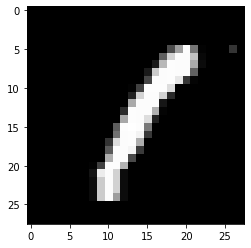

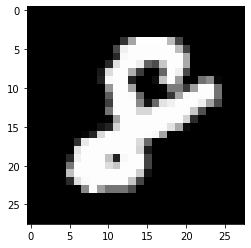

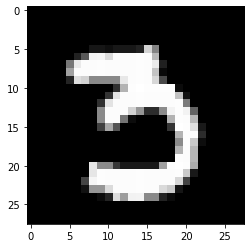

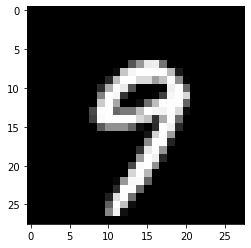

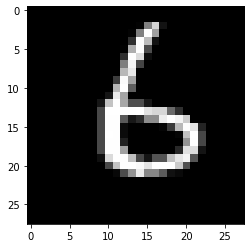

In [4]:
# create 5 image plots showing MNIST images
dataiter = iter(train_loader)
images, labels = dataiter.__next__()
imgs = images.squeeze()
    
for img in range(5):
    plt.figure(img)
    plt.imshow(imgs[img], cmap='gray')
plt.show()

In [5]:
# view the dimensions and num classes of the input images
for images, labels in train_loader:
    print("Image Batch Dimensions: ", images.shape)
    print("Single Image Dimensions: ", images[0].shape)
    print("Labels Batch Dimensions: ", labels.shape)
    break

print("Train Dataset # Classes: ", len(train.classes))
print("Test Dataset # Classes: ", len(test.classes))

Image Batch Dimensions:  torch.Size([64, 1, 28, 28])
Single Image Dimensions:  torch.Size([1, 28, 28])
Labels Batch Dimensions:  torch.Size([64])
Train Dataset # Classes:  10
Test Dataset # Classes:  10


In [6]:
# SNN class with model
class SiameseNeuralNetwork(Module):
    def __init__(self):
        super(SiameseNeuralNetwork, self).__init__()
        # First L-2 layers have convolutions followed by max pooling and activation ReLU
        # The L-1 layer is a Dense layer which will give a feature vector with activation Sigmoid
        # The L layer (output layer) will then compute the classification
        self.conv1 = Conv2d(in_channels=1, out_channels=32, kernel_size=7, stride=1, padding='same')
        self.pool1 = MaxPool2d(kernel_size=2, stride=2, padding=1)

        self.conv2 = Conv2d(in_channels=32, out_channels=64, kernel_size=5, stride=1, padding='same')
        self.pool2 = MaxPool2d(kernel_size=2, stride=2, padding=1)

        self.conv3 = Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding='same')
        self.pool3 = MaxPool2d(kernel_size=2, stride=2, padding=1)

        self.conv4 = Conv2d(in_channels=128, out_channels=256, kernel_size=3, stride=1, padding='same')

        self.fc1 = Linear(in_features=6400, out_features=1024)
        self.fc2 = Linear(in_features=1024, out_features=10)

    def forward_on_input(self, x):
        x = self.pool1(F.relu(self.conv1(x)))
        x = self.pool2(F.relu(self.conv2(x)))
        x = self.pool3(F.relu(self.conv3(x)))
        x = F.relu(self.conv4(x))

        x = x.flatten(start_dim=1)

        x = torch.sigmoid(self.fc1(x))
        return x

    def forward(self, x1, x2):
        y1 = self.forward_on_input(x1)
        y2 = self.forward_on_input(x2)
        d = torch.abs(y1 - y2)
        p = self.fc2(d)
        return p

In [7]:
# Train the model
model = SiameseNeuralNetwork()

# If a GPU is available, then send it to that GPU rather than train on CPU
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
num_epochs = 10

In [8]:
# show model summary
print(model)

SiameseNeuralNetwork(
  (conv1): Conv2d(1, 32, kernel_size=(7, 7), stride=(1, 1), padding=same)
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=1, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1), padding=same)
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=1, dilation=1, ceil_mode=False)
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (pool3): MaxPool2d(kernel_size=2, stride=2, padding=1, dilation=1, ceil_mode=False)
  (conv4): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (fc1): Linear(in_features=6400, out_features=1024, bias=True)
  (fc2): Linear(in_features=1024, out_features=10, bias=True)
)


In [9]:
# set the loss, optimizer, and model device
loss = torch.nn.CrossEntropyLoss()
opt = torch.optim.Adam(model.parameters(), lr=0.05)
model = model.to(device)

In [10]:
# Compute the accuracy of the model at each epoch
def accuracy(output, target, batch_size):
    corrects = (torch.max(output, 1)[1].view(target.size()).data == target.data).sum()
    accuracy = 100.0 * corrects / batch_size
    return accuracy.item()

In [11]:
# training
for epoch in range(num_epochs):
    train_running_loss = 0.0
    train_accuracy = 0.0
    model = model.train()

    # training step: iterate through the batch and get the images and labels at each x
    for x, (images, labels) in enumerate(train_loader):
        # sending images and labels to device (GPU or CPU)
        images = images.to(device)
        labels = labels.to(device)

        # pass 2 sets of inputs into the snn and gives p, the output
        output = model(images, images)
        losses = loss(output, labels)

        opt.zero_grad()
        losses.backward()
        opt.step()

        train_running_loss += losses.item()
        train_accuracy += accuracy(output, labels, batch_size)

    model.eval()
    print('Epoch %d | Loss: %.4f | Train Accuracy: %.2f'%(epoch+1, train_running_loss / x, train_accuracy / x))

Epoch 1 | Loss: 2.3083 | Train Accuracy: 10.36
Epoch 2 | Loss: 2.3080 | Train Accuracy: 10.58
Epoch 3 | Loss: 2.3083 | Train Accuracy: 10.58
Epoch 4 | Loss: 2.3082 | Train Accuracy: 10.56
Epoch 5 | Loss: 2.3082 | Train Accuracy: 10.34
Epoch 6 | Loss: 2.3082 | Train Accuracy: 10.57
Epoch 7 | Loss: 2.3082 | Train Accuracy: 10.78
Epoch 8 | Loss: 2.3076 | Train Accuracy: 10.67
Epoch 9 | Loss: 2.3080 | Train Accuracy: 10.52
Epoch 10 | Loss: 2.3080 | Train Accuracy: 10.61


In [12]:
test_accuracy = 0.0
for y, (images, labels) in enumerate(test_loader):
    images = images.to(device)
    labels = labels.to(device)

    outputs = model(images, images)
    test_accuracy += accuracy(outputs, labels, batch_size)
print('Test Accuracy: %.2f'%(test_accuracy / y))

Test Accuracy: 11.37
